### Expectation-Maximization for Clustering (Movie Reviews)
In this notebook, I will demonstrate how the expectation-maximization (EM) algorithm can be applied to document clustering. The (soft) EM algorithm involves iterations with two steps, an expectation (E) step which creates an expectation of the log-likelihood using the current estimates for the parameters, and a maximization (M) step, which computes values for the parameters maximizing the expectation of the log-likelihood from the E step. The Hard EM algorithm works similarly, with the exception of assigning each data point to a single cluster instead of creating an expectation.

In document clustering, the parameters to be optimised are the cluster proportions and the word proportions for each cluster.

For more detailed information about the mathematics behind the EM algorithm, consult further resources such as this Wikipedia article: https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm

In [1]:
# Import required libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

In [2]:
class SoftEM:
    
    def __init__(self, K, tau_max=100):
        self.K = K               
        self.tau_max = tau_max  

        self.cluster_probs = None     # placeholder for mixing ratio
        self.word_probs = None      # placeholder for cluster member effective counts

    def fit(self, x):
        n_samples = x.shape[0]
        n_words = x.shape[1]
        # initialization:
        # start with equal probs for each cluster
        self.cluster_probs = np.array([1/self.K] * self.K) 
        # Start with random weightings for the words
        # Need to normalise so each row sums to 1
        # Numpy has some weird defaults, need to covert to 2D array
        self.word_probs = np.random.rand(self.K,n_words)
        word_probs_norm_coeff = np.sum(self.word_probs,axis=1,keepdims=True)
        self.word_probs = self.word_probs/np.array(word_probs_norm_coeff)
        
        terminate= False
        tau = 1
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        cluster_probs_old = self.cluster_probs
        word_probs_old = self.word_probs
        cluster_preds = np.zeros((n_samples,self.K))
        while (not terminate):

            # E step:
            for n in range(0,n_samples):
                for k in range(0,self.K):
                    # calculate the log likelihood of cluster given doc based on the estimated cluster probs and word-cluster probs
                    cluster_raw_word_preds = np.multiply(x[n], np.where(self.word_probs[k]>0,np.log(self.word_probs[k]),-100))
                    cluster_word_preds_sum = np.sum(cluster_raw_word_preds)
                    cluster_preds[n,k] = np.log(self.cluster_probs[k]) + cluster_word_preds_sum
                # Normalise the total probs to 1 for each doc
                # Also takes probs out of log space
                cluster_preds[n] = np.exp(cluster_preds[n])
                cluster_preds_norm_coeff = np.sum(cluster_preds[n])
                cluster_preds[n] = cluster_preds[n]/cluster_preds_norm_coeff

            # M step
            # Cluster probs
            self.cluster_probs = np.sum(cluster_preds,axis=0)/n_samples
            # Word probs
            for k in range(0,self.K):
                cluster_word_freqs = np.sum((cluster_preds[:,k].reshape(n_samples,1)*x),axis=0)
                cluster_word_freqs_norm_coeff = np.sum(cluster_word_freqs)
                self.word_probs[k] = cluster_word_freqs/cluster_word_freqs_norm_coeff

            # increase iteration counter
            tau +=1
            # check termination condition
            terminate = tau == self.tau_max or (np.array_equal(cluster_probs_old, self.cluster_probs) and np.array_equal(word_probs_old, self.word_probs))
            cluster_probs_old = self.cluster_probs
            word_probs_old = self.word_probs
        print("Finished fitting at iteration", tau)
        
        
    # In a clustering-context, `predict` is equivalent to obtaining cluster assignments for new data
    def predict(self, x):
        n_samples = x.shape[0]
        n_words = x.shape[1]
        cluster_preds = np.zeros((n_samples, self.K))
        for n in range(0,n_samples):
            for k in range(0,self.K):
                # calculate the log likelihood of cluster given doc based on the estimated cluster probs and word-cluster probs
                cluster_raw_word_preds = np.multiply(x[n], np.where(self.word_probs[k]>0,np.log(self.word_probs[k]),-100))
                cluster_word_preds_sum = np.sum(cluster_raw_word_preds)
                cluster_preds[n,k] = np.log(self.cluster_probs[k]) + cluster_word_preds_sum
            # Normalise the total probs to 1 for each doc
            # Also takes probs out of log space
            cluster_preds[n] = np.exp(cluster_preds[n])
            cluster_preds_norm_coeff = np.sum(cluster_preds[n])
            cluster_preds[n] = cluster_preds[n]/cluster_preds_norm_coeff
        return cluster_preds

In [3]:
class HardEM:
    
    def __init__(self, K, tau_max=100):
        self.K = K               
        self.tau_max = tau_max  

        self.cluster_probs = None     # placeholder for mixing ratio
        self.word_probs = None      # placeholder for cluster member effective counts

    def fit(self, x):
        n_samples = x.shape[0]
        n_words = x.shape[1]
        # initialization:
        # start with equal probs for each cluster
        self.cluster_probs = np.array([1/self.K] * self.K) 
        # Start with random weightings for the words
        # Need to normalise so each row sums to 1
        # Numpy has some weird defaults, need to covert to 2D array
        self.word_probs = np.random.rand(self.K,n_words)
        word_probs_norm_coeff = np.sum(self.word_probs,axis=1,keepdims=True)
        self.word_probs = self.word_probs/np.array(word_probs_norm_coeff)
        
        terminate= False
        tau = 1
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        cluster_probs_old = self.cluster_probs
        word_probs_old = self.word_probs
        cluster_preds = np.zeros((n_samples,self.K))
        while (not terminate):
            # E step:
            for n in range(0,n_samples):
                for k in range(0,self.K):
                    # calculate the log likelihood of cluster given doc based on the estimated cluster probs and word-cluster probs
                    cluster_raw_word_preds = np.multiply(x[n], np.where(self.word_probs[k]>0,np.log(self.word_probs[k]),-10))
                    cluster_word_preds_sum = np.sum(cluster_raw_word_preds)
                    cluster_preds[n,k] = np.log(self.cluster_probs[k]) + cluster_word_preds_sum
                # Make argmax of the preds 1, all the rest 0
                cluster_preds[n] = np.exp(cluster_preds[n])
                best_k = np.argmax(cluster_preds[n])
                cluster_preds[n] = np.zeros(self.K)
                cluster_preds[n,best_k] = 1

            # M step
            # Cluster probs
            self.cluster_probs = np.sum(cluster_preds,axis=0)/n_samples
            # Word probs
            for k in range(0,self.K):
                cluster_word_freqs = np.sum((cluster_preds[:,k].reshape(n_samples,1)*x),axis=0)
                cluster_word_freqs_norm_coeff = np.sum(cluster_word_freqs)
                self.word_probs[k] = cluster_word_freqs/cluster_word_freqs_norm_coeff


            # increase iteration counter
            tau +=1
            # check termination condition
            terminate = tau == self.tau_max or (np.array_equal(cluster_probs_old, self.cluster_probs) and np.array_equal(word_probs_old, self.word_probs))
            cluster_probs_old = self.cluster_probs
            word_probs_old = self.word_probs
        print("Finished fitting at iteration", tau)
        
        
    # In a clustering-context, `predict` is equivalent to obtaining cluster assignments for new data
    def predict(self, x):
        n_samples = x.shape[0]
        n_words = x.shape[1]
        cluster_preds = np.zeros((n_samples, self.K))
        for n in range(0,n_samples):
            for k in range(0,self.K):
                # calculate the log likelihood of cluster given doc based on the estimated cluster probs and word-cluster probs
                cluster_raw_word_preds = np.multiply(x[n], np.where(self.word_probs[k]>0,np.log(self.word_probs[k]),-10))
                cluster_word_preds_sum = np.sum(cluster_raw_word_preds)
                cluster_preds[n,k] = np.log(self.cluster_probs[k]) + cluster_word_preds_sum
            # Make argmax of the preds 1, all the rest 0
            cluster_preds[n] = np.exp(cluster_preds[n])
            best_k = np.argmax(cluster_preds[n])
            cluster_preds[n] = np.zeros(self.K)
            cluster_preds[n,best_k] = 1
        return cluster_preds

The dataset we will use is a set of genre labelled IMDB reviews, sourced from Kaggle user radmirkaz at https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb. I've converted the file into a tab-separated values file beforehand (from the original with " ::: " separators).

In [4]:
df = pd.read_csv('labelled_IMDB_reviews.tsv', header=0, names=["index","title","genre","description"], sep='\t', error_bad_lines=False)

C:\Users\theta\AppData\Local\Temp\ipykernel_4556\1407532867.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('labelled_IMDB_reviews.tsv', header=0, names=["index","title","genre","description"], sep='\t', error_bad_lines=False)
b'Skipping line 1138: expected 4 fields, saw 6\nSkipping line 10845: expected 4 fields, saw 6\nSkipping line 34666: expected 4 fields, saw 6\nSkipping line 37825: expected 4 fields, saw 6\nSkipping line 49822: expected 4 fields, saw 6\n'


Let's take a closer look at the contents of this file:

In [5]:
df.head(n=20)

,index,title,genre,description
0,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
1,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
2,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
3,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...
4,6,Riddle Room (2016),horror,Emily Burns is being held captive in a room wi...
5,7,L'amica (1969),drama,The beautiful but neglected wife of a brillian...
6,8,Ina Mina Dika (1989),comedy,Vasu Inamdar (Ina) suffers from a disorder whe...
7,9,Equinox Special: Britain's Tornados (2005),documentary,An insight into the tornados that hit Kensal R...
8,10,Press (2011),drama,Press is a story of young people overwhelmed b...
9,11,The Firm Man (1975),drama,Not much is known about the firm for which bus...


We can see that two columns, corresponding to movie title and file index won't be useful for our EM algorithm. The genre column will be our labels for evaluation, while the description column contains our documents to apply the EM algorithm. 

In [6]:
df.drop(columns=["index","title"],inplace=True)

There are a lot of different genres of movie in our dataset. To simplify our task (and make later evaluation easier) we will select 4 genres of movie and discard the rest.

In [7]:
df = df[(df.genre.isin(["family", "adventure", "romance", "sci-fi"]))]

In [8]:
df.head(n=20)

,genre,description
26,family,"A 14 year-old skeptic falls 3 stories, in a co..."
36,romance,"Shy bookworm Tommy vacations in Palm Springs, ..."
65,family,There's nonstop fun as Barney and his friends ...
144,sci-fi,Science is on the verge of discovering a mecha...
146,family,A marathon TV show on the day of the opening o...
176,adventure,Belle follows the sharp-witted heroine of the ...
193,romance,"Based on the manga with the same name, the sto..."
242,family,A look at every occasion fromclass parties to ...
273,romance,Rishabh and Parineeta are both deeply in love ...
279,family,This is the Story of Jesus for Children. It be...


Next, we need to convert these textual documents into a set of numerical features. To do this, I will convert the text into td-idf form using `sklearn.feature_extraction.text`.

In [9]:
tf_idf = TfidfVectorizer(lowercase=True, stop_words='english', min_df=10, norm='l2')
features = tf_idf.fit_transform(raw_documents=df.description.values)
features_array = features.toarray()

We can now apply both the Soft EM and Hard EM algorithms to the documents, and then predict the genres:

In [10]:
# Set the RNG for numpy
np.random.seed(0)

In [11]:
softEM = SoftEM(K=4)
softEM.fit(features_array)
soft_EM_labels = softEM.predict(features_array)

Finished fitting at iteration 100


In [12]:
hardEM = SoftEM(K=4)
hardEM.fit(features_array)
hard_EM_labels = softEM.predict(features_array)

Finished fitting at iteration 100


Now that I have applied the Soft and Hard EM algorithms and gotten predicted labels, I can visualise these predictions against the true genre labels to make a qualitative analysis about the prediction quality of our EM guesses. In order to effectively visualise these labellings, I will need to reduce the dimensionality of the data to 2 dimensions.

In [13]:
# function to convert the genres to labels
def genres_to_labels(genres):
    convert_dict = {"family": 0, "adventure": 1, "romance": 2, "sci-fi": 3}
    labels = [convert_dict[genre] for genre in genres]
    return labels

In [14]:
# Get True labels
true_genres = df.genre.values
true_labels = genres_to_labels(true_genres)

In [15]:
# Conduct PCA -> 2D on features
pca_features = PCA(n_components=2)
_2D_features = pca_features.fit_transform(features_array)

Text(0, 0.5, 'x2')

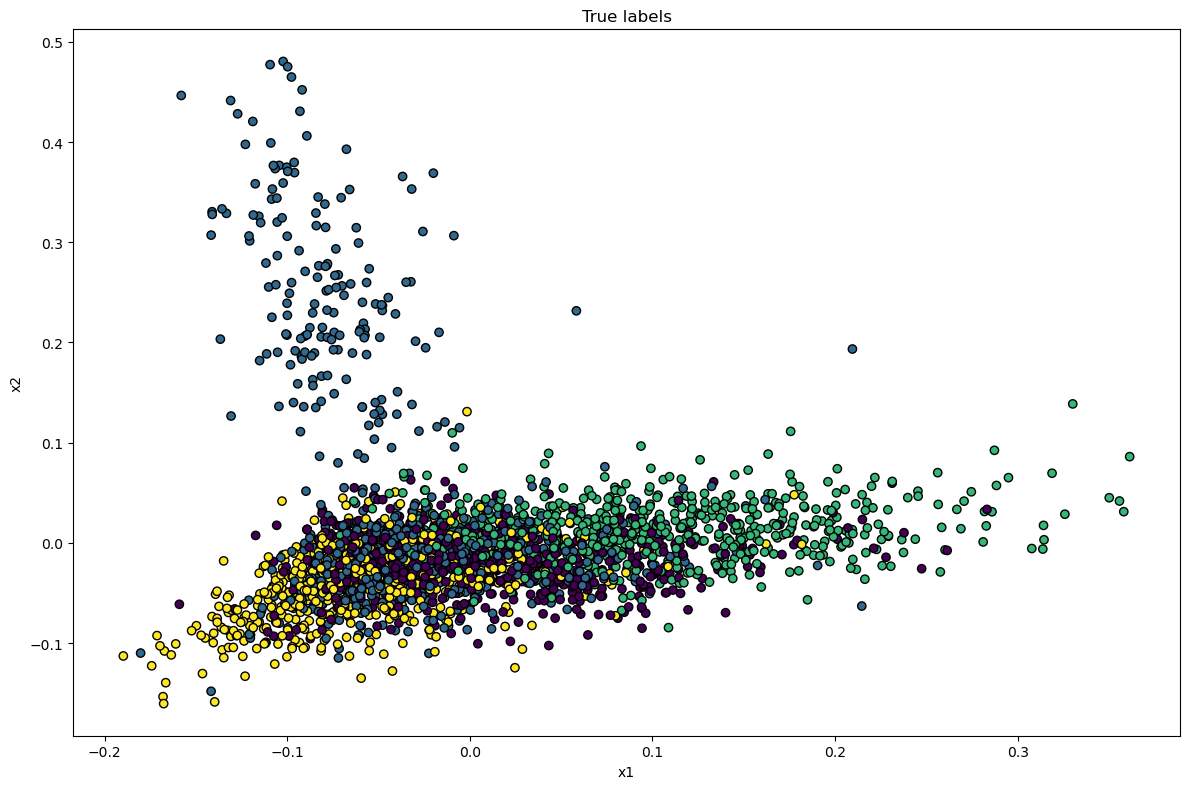

In [16]:
# Visualise the true labels
_, axs = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
axs.scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=true_labels, edgecolors = "black")
axs.set_title('True labels')
axs.set_xlabel('x1')
axs.set_ylabel('x2')


Text(0, 0.5, 'x2')

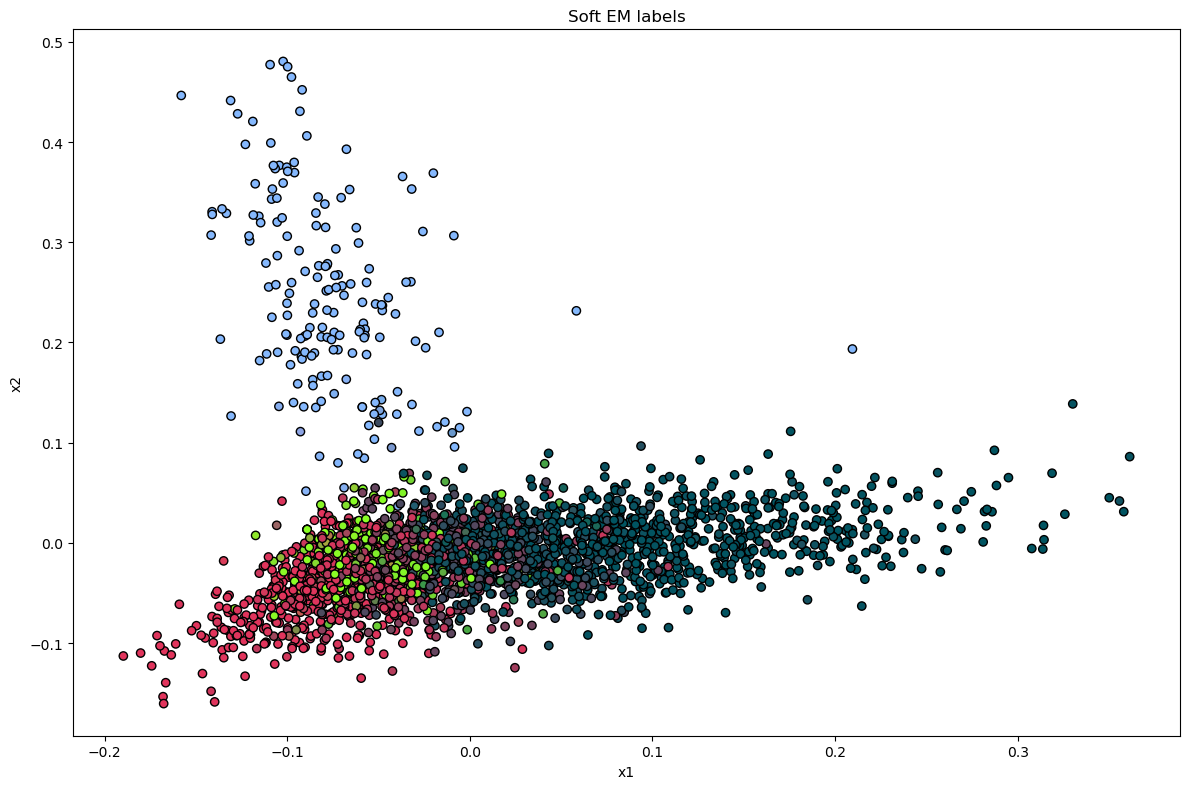

In [17]:
# Visualise the Soft EM labels

# Convert cluster probabilities to RGB colours
pca_rgb = PCA(n_components=3)
soft_EM_labels_rgb = pca_rgb.fit_transform(soft_EM_labels)
soft_EM_labels_rgb -= np.min(soft_EM_labels_rgb)
soft_EM_labels_rgb /= np.max(soft_EM_labels_rgb)

_, axs = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
axs.scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=soft_EM_labels_rgb, edgecolors="black")
axs.set_title('Soft EM labels')
axs.set_xlabel('x1')
axs.set_ylabel('x2')


Text(0, 0.5, 'x2')

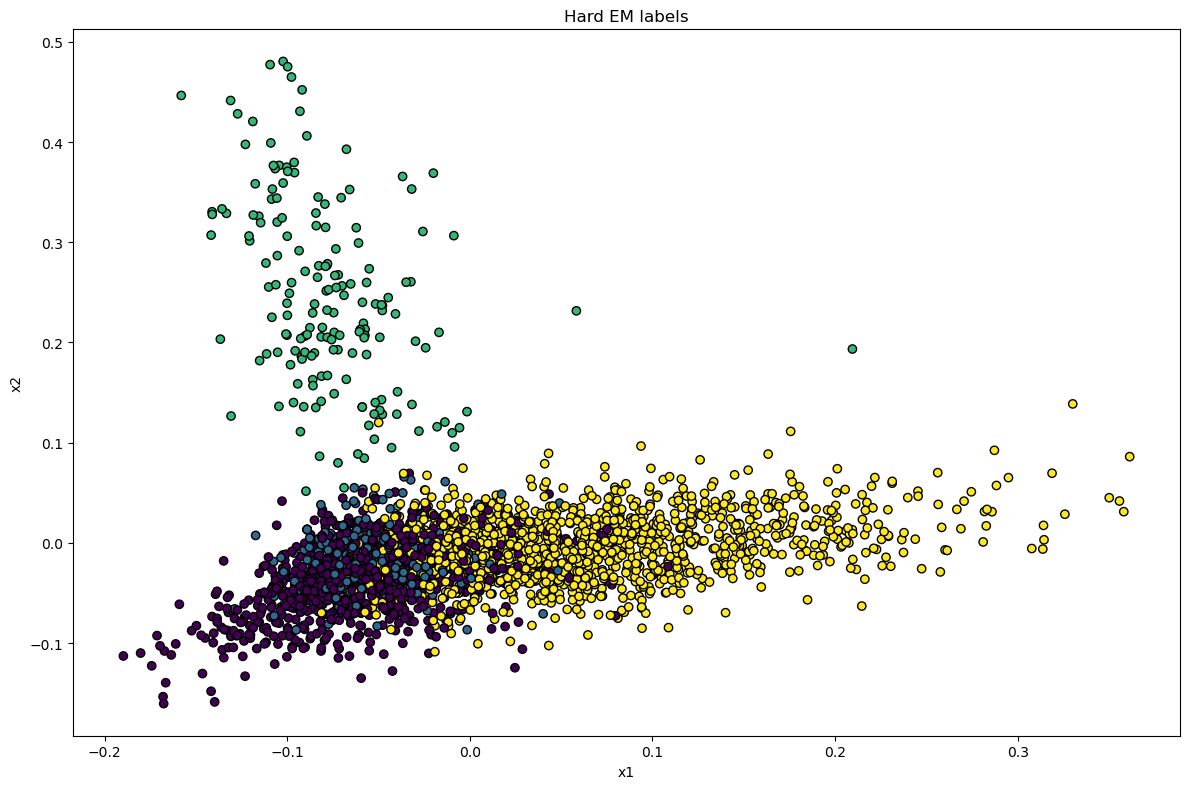

In [18]:
# Visualise the Hard EM labels
hard_EM_labels = np.argmax(hard_EM_labels,axis=1)

_, axs = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
axs.scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=hard_EM_labels, edgecolors = "black")
axs.set_title('Hard EM labels')
axs.set_xlabel('x1')
axs.set_ylabel('x2')


We can see that the Soft EM clusters more closely approximate the actual true genre labels (particularly due to allowing uncertainty in the region where the clusters intersect), however the Hard EM algorithm was significantly faster to calculate. Altough neither Soft EM clusters or Hard EM clusters perfectly matched up to the truth, I have demonstrated the the EM algorithm can be used to obtain reasonable estimates of parameters for distributions (and thus reasonable estimates of cluster memberships).